In [1]:
# Load scenarios

%matplotlib inline

from collections import Counter, defaultdict
import glob
import gzip
import json
import math
from operator import itemgetter
import os
from pathlib import Path

from IPython.display import display, Markdown
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from pygtrie import StringTrie
import seaborn as sns

EDR_CALIBRATION_RESULTS = Path("./js-benchmark-variance")
EJS_BENCHMARK = Path("./ejs-benchmark")

In [2]:
data = defaultdict(list)

def load_results(dir_path, engine):
    for filepath in glob.iglob(os.path.join(dir_path, "*.json")):
        total = 0
        failure_count = 0
        with open(filepath) as f:
            measurements = json.load(f)
        for key, value in measurements.items():
            data["engine"].append(engine)
            data["scenario"].append(key)
            data["timeS"].append(value["timeMs"] / 1000)
            data["failureCount"].append(len(value["failures"]))
            total += value["timeMs"] / 1000
            failure_count += len(value["failures"])
        data["engine"].append(engine)
        data["scenario"].append("total")
        data["timeS"].append(total)
        data["failureCount"].append(failure_count)

load_results(EDR_CALIBRATION_RESULTS, "edr")
load_results(EJS_BENCHMARK, "ejs")

df = pd.DataFrame(data)

In [3]:
df.groupby(["scenario", "engine"]).median()

timeS  failureCount
scenario                             engine                           
neptune-mutual-blue-protocol_8db6480 edr      843.775911         567.5
                                     ejs      405.027118         553.0
openzeppelin-contracts_0a5fba7a      edr      116.439523        1640.0
                                     ejs       71.894457        2185.0
rocketpool_6a9dbfd8                  edr       75.136913         390.0
                                     ejs      153.591012        1141.0
safe-contracts_914d0f8               edr        3.470199         193.0
                                     ejs        6.933748         366.0
seaport_4f4e7c20                     edr       18.247284         305.0
                                     ejs       33.046501        1584.0
synthetix_9a3a109f                   edr     2802.367727       10264.0
                                     ejs      383.959110       21317.0
total                                edr     3897.134493       13521.0
                                     ejs     1073.992274       27405.0
uniswap-v3-core_d8b1c63              edr       43.896538         172.0
                                     ejs       17.686641         259.0

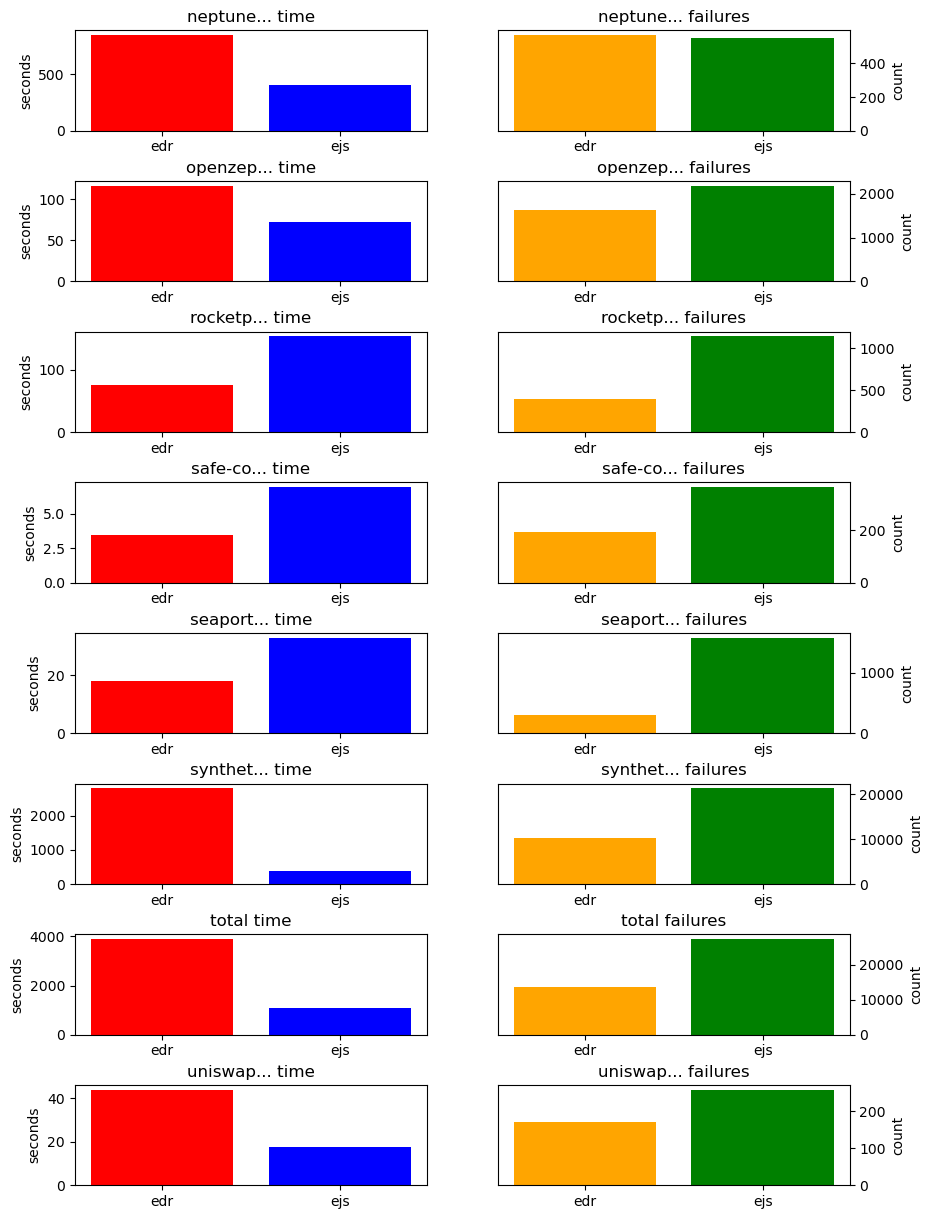

In [35]:
scenarios = sorted(df["scenario"].unique())


fig, axs = plt.subplots(len(df["scenario"].unique()), 2, figsize=(10, 15), squeeze=False)

for i, [ax_time, ax_fail] in enumerate(axs):
    scenario = scenarios[i]
    times_x = []
    times_y = []
    failures_x = []
    failures_y = []
    for [(s, engine), row] in df.groupby(["scenario", "engine"]).median().iterrows():
        if s != scenario:
            continue
        times_x.append(engine)
        times_y.append(row["timeS"])
        failures_x.append(engine)
        failures_y.append(row["failureCount"])
        
    scen_title = scenario if len(scenario) <= 10 else f"{scenario[:7]}..."

    ax_time.set_title(f"{scen_title} time")
    ax_time.bar(times_x, times_y, color=["red", "blue"])
    ax_time.set_ylabel("seconds")
    
    ax_fail.set_title(f"{scen_title} failures")
    ax_fail.bar(failures_x, failures_y, color=["orange", "green"])
    ax_fail.set_ylabel("count")
    ax_fail.yaxis.tick_right()
    ax_fail.yaxis.set_label_position("right")

plt.subplots_adjust(hspace=0.5)
plt.show()

In [36]:
display(Markdown("Ratio of max/min time for each scenario"))
df.groupby(["scenario", "engine"])["timeS"].max() / df.groupby(["scenario", "engine"])["timeS"].min()

Ratio of max/min time for each scenario

scenario                              engine
neptune-mutual-blue-protocol_8db6480  edr       1.027792
                                      ejs       1.027107
openzeppelin-contracts_0a5fba7a       edr       1.033313
                                      ejs       1.009352
rocketpool_6a9dbfd8                   edr       1.085846
                                      ejs       1.012139
safe-contracts_914d0f8                edr       1.143591
                                      ejs       1.012202
seaport_4f4e7c20                      edr       1.102685
                                      ejs       1.018182
synthetix_9a3a109f                    edr       1.383402
                                      ejs       1.019264
total                                 edr       1.252346
                                      ejs       1.009594
uniswap-v3-core_d8b1c63               edr       1.045688
                                      ejs       1.022227
Name: timeS, dtype: float64